In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from darts import TimeSeries
from darts.datasets import AirPassengersDataset
from matplotlib import pyplot as plt
import pandas as pd
import nltk
import numpy as np
import spacy
from spacy import displacy
from spacy import tokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rajenderkapur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Reading the Macro-data for Reliance

In [2]:
# This is the excel file to read the macro data
Macrodf = pd.read_excel('Stock-data.xlsx')

# Removing the first unamed column 
Macrodf = Macrodf.drop(columns=['Unnamed: 0'])

#Changing the dtype of the date column to get into correct date-time format
Macrodf.Date = pd.to_datetime(Macrodf.Date)

# Renaming the last two columns to the right name 
renamingcols = {'INR_x':'Gold_Price','INR_y':'USD_Exchange_Rate','INR':'Brent_Oil'}
Macrodf = Macrodf.rename(columns=renamingcols)

# Remove some outlying problems with Brent oul and Gold Prices on 2022-04-08 and 2022-05-26	
# mask = (Macrodf['Brent_Oil'] < 100) & (Macrodf['Gold_Price'] < 100)
# Macrodf.loc[mask,'Breant_Oil'] = np.NaN
# Macrodf.loc[mask,'Gold_Price'] = np.NaN

### Using Darts 
1) Convert dataframe into timeseries format 
2) 

In [4]:
# Making into Timeseries object as required by Darts
Macro = TimeSeries.from_dataframe(df = Macrodf,time_col='Date',fill_missing_dates=True,freq='D')

#### Checking how the series evolve over time


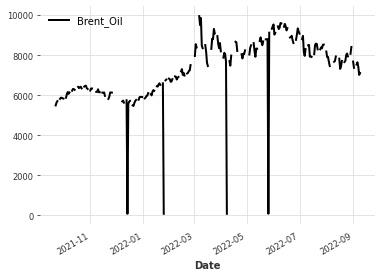

In [5]:
Macro['Brent_Oil'].plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

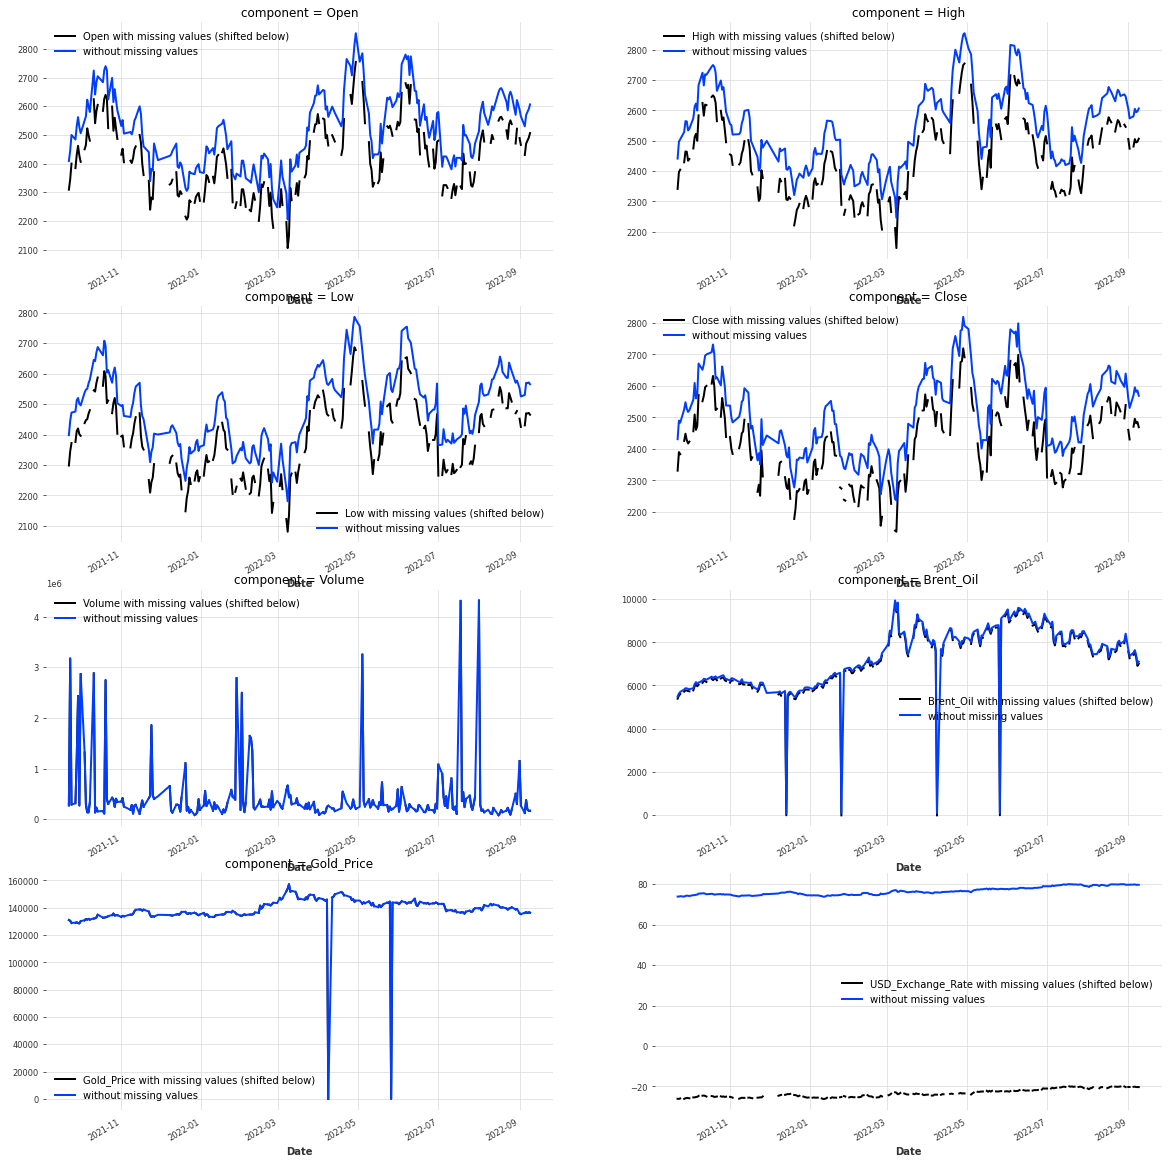

In [6]:
from darts.utils.missing_values import fill_missing_values
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
ax = ax.ravel()
i = 0 
for col in list(Macro.columns):
    (Macro[col] - 100).plot(label=f"{col} with missing values (shifted below)",ax = ax[i])
    fill_missing_values(Macro[col]).plot(label="without missing values",ax = ax[i])
    ax[i].legend()
    i+=1

plt.show()



In [7]:
# Filling Missing Values 
Macro = fill_missing_values(Macro)

# Checking Seasonality
from darts.utils.statistics import plot_acf, check_seasonality
for col in Macro.columns:
    for m in range(2, 25):
        is_seasonal, period = check_seasonality(Macro[col], m=m, alpha=0.05)
        if is_seasonal:
            print("There is seasonality of order {} in this {}.".format(period,col))

There is seasonality of order 9 in this Volume.
There is seasonality of order 14 in this Volume.
There is seasonality of order 15 in this Brent_Oil.
There is seasonality of order 18 in this Brent_Oil.
There is seasonality of order 22 in this Brent_Oil.
There is seasonality of order 10 in this Gold_Price.
There is seasonality of order 16 in this Gold_Price.
There is seasonality of order 20 in this Gold_Price.


In [8]:
# fix python path if working locally
# from utils import fix_pythonpath_if_working_locally

# fix_pythonpath_if_working_locally()

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

#### Split the target variable and also generate past covariates

In [9]:
covcols =['Open', 'High', 'Low', 'Volume', 'Brent_Oil', 'Gold_Price', 'USD_Exchange_Rate']

In [21]:
# Data Preprocessing to scale the data before splitting
macro_scale = Scaler()
Macro = macro_scale.fit_transform(Macro)
# The target variable is first split into last 50 periods 
taget_train,target_val = Macro['Close'][:-50],Macro['Close'][-50:]
covariate_train,covariate_val = Macro[covcols][:-50],Macro[covcols][-50:]

In [28]:
model_cov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=50,
    output_chunk_length=24,
    n_epochs=300,
    random_state=0,
)

/Users/rajenderkapur/miniconda3/envs/stockprice/lib/python3.9/site-packages/darts/timeseries.py:4079: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
2022-09-14 10:44:21 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-14 10:44:21 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-14 10:44:21 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-14 10:44:21 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
/Users/rajenderkapur/miniconda3/envs/stockprice/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
2022-09-14 10:44:21

Training: 0it [00:00, ?it/s]

2022-09-14 10:44:48 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=300` reached.


Predicting: 8it [00:00, ?it/s]

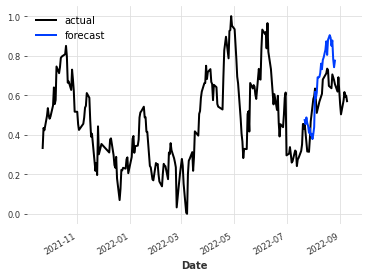

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

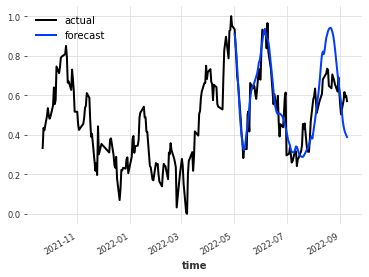

MAPE (using covariates) = 14.94%


In [29]:
model_cov.fit(
    series=taget_train,
    past_covariates=covariate_train,
    verbose=True,
)
pred_cov = model_cov.predict(n=36, series=taget_train, past_covariates=Macro[covcols])
Macro['Close'].plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()
plt.show()

backtest_cov = model_cov.historical_forecasts(
    Macro['Close'],
    past_covariates=Macro[covcols],
    start=0.6,
    forecast_horizon=12,
    stride=1,
    retrain=False,
    verbose=False,
)

Macro['Close'].plot(label="actual")
backtest_cov.plot(label="forecast")
plt.legend()
plt.show()
print("MAPE (using covariates) = {:.2f}%".format(mape(Macro['Close'], backtest_cov)))

### The text data

In [11]:
sentiments = pd.read_excel('allarticles.xlsx')
sentiments = sentiments.drop(columns='Unnamed: 0')

In [13]:
# Converting all date columns into yyyy-mm-dd form 
datecols = ['Date','Date.1','Date.2','Date.3']
opinioncols = ['Politics','Headlines','News_titles','Tweets']


# Function to convert columns into datetime format
def todatetime(dataframe):
    for col in datecols:
        dataframe[col] = pd.to_datetime(pd.to_datetime(dataframe[col]).dt.date)
    return dataframe


# Cleaning function
def cleaning(dataframe):
    # First just keeping words and removing special characters in this case
    dataframe = dataframe.replace('[^a-zA-Z]'," ",regex = True)
    # Getting all the stopwords
    all_stopwords = stopwords.words('english')
    # Removing some stopwords which may be important
    all_stopwords.remove('not')
    all_stopwords.remove("wasn't")
    # Lemmatizing the words
    wnl = WordNetLemmatizer()
    # Then removing all the stopwords
    for col in opinioncols:
        processed = []
        for i in range(len(dataframe[col])):
            # Lowering all the sentences before stemming and lemmatosation
            processing = str(dataframe[col][i]).lower()
            processing = nltk.word_tokenize(processing)
            processing = [wnl.lemmatize(word) for word in processing if word not in all_stopwords]
            final = ' '.join(processing)
            processed.append(final)
        # This is to get the right values in the column
        dataframe[col] = processed

    return dataframe

def all(dataframe):
    g = todatetime(dataframe)
    g = cleaning(dataframe)
    return g

sentiments = all(sentiments)
